In [12]:
# Importing packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
import os
import scipy.io
from scipy.signal import butter, filtfilt, find_peaks
#from google.colab import drive
import datetime
import seaborn
import keras
import random
import numpy as np
import csv
import requests
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd

In [13]:

url = 'https://archive.physionet.org/physiobank/database/challenge/2015/training/RECORDS'

response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:

    text = response.text
    print("Successfully retrieve the patient Id's Status code:", response.status_code)
else:
    print("Failed to retrieve the text content. Status code:", response.status_code)

lines = text.strip().split('\n')

csv_file = 'record_names.csv'

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([[line] for line in lines])

print(f'CSV file "{csv_file}" has been created.')


Successfully retrieve the patient Id's Status code: 200
CSV file "record_names.csv" has been created.


In [14]:

csv_file = 'record_names.csv'

patient_ids_df = pd.read_csv(csv_file, header=None)

patient_ids = patient_ids_df.to_numpy().reshape(-1)

print(patient_ids)

['v100s' 'v101l' 'v102s' 'a103l' 'a104s' 'a105l' 't106s' 't107l' 't108s'
 'a109l' 't110s' 'v111l' 't112s' 'v113l' 't114s' 'v115l' 't116s' 't117l'
 't118s' 'v119l' 'f120s' 'f121l' 'v122s' 'a123l' 'b124s' 'b125l' 'b126s'
 'v127l' 'v128s' 'f129l' 'f130s' 'v131l' 'v132s' 'v133l' 'a134s' 'v135l'
 'v136s' 'f137l' 'f138s' 'v139l' 'v140s' 'v141l' 'a142s' 'v143l' 'f144s'
 'a145l' 'v146s' 'v147l' 'v148s' 't149l' 't150s' 't151l' 'a152s' 'v153l'
 'v154s' 'v155l' 't156s' 't157l' 'v158s' 'v159l' 'v160s' 'a161l' 'v162s'
 'a163l' 'v164s' 'a165l' 'v166s' 'a167l' 'v168s' 'v169l' 'a170s' 'a171l'
 'a172s' 't173l' 't174s' 't175l' 'v176s' 'v177l' 'a178s' 'v179l' 'v180s'
 'v181l' 'v182s' 'b183l' 'b184s' 'a185l' 'a186s' 'b187l' 'v188s' 'f189l'
 'f190s' 't191l' 't192s' 't193l' 'v194s' 't195l' 'f196s' 'v197l' 'v198s'
 'v199l' 'v200s' 'v201l' 'v202s' 'a203l' 'v204s' 'v205l' 'v206s' 'v207l'
 't208s' 't209l' 'v210s' 'v211l' 'v212s' 't213l' 't214s' 'b215l' 'b216s'
 'v217l' 'v218s' 'a219l' 'b220s' 'v221l' 'v222s' 'a

In [15]:
import os
import requests

def download_file(url, dest_path):
    if not os.path.exists(dest_path):
        print(f"Downloading {url}...")
        r = requests.get(url)
        if r.status_code == 200:
            with open(dest_path, 'wb') as f:
                f.write(r.content)
            print(f"Saved to {dest_path}")
        else:
            print(f"Failed to download {url}. Status code: {r.status_code}")
    else:
        print(f"File already exists: {dest_path}")

def extracting_database(record_name, data_dir='./training'):
    os.makedirs(data_dir, exist_ok=True)

    base_url = 'https://archive.physionet.org/physiobank/database/challenge/2015/training/'

    mat_url = f"{base_url}{record_name}.mat"
    hea_url = f"{base_url}{record_name}.hea"

    record_path = os.path.join(data_dir, f"{record_name}.mat")
    hea_file_path = os.path.join(data_dir, f"{record_name}.hea")

    download_file(mat_url, record_path)
    download_file(hea_url, hea_file_path)

    return record_path, hea_file_path


In [16]:
record_name = 'a103l'
record_path, hea_file_path = extracting_database(record_name)


File already exists: ./training/a103l.mat
File already exists: ./training/a103l.hea


In [17]:
def extract_pleth_signal(record_path):

    mat_data = scipy.io.loadmat(record_path)

    signals = mat_data['val']

    pleth_signal = signals[2]  # PLETH is the third signal

    return pleth_signal

record_name = 'a103l'
record_path, hea_file_path = extracting_database(record_name)
pleth_signal = extract_pleth_signal(record_path)
pleth_signal

File already exists: ./training/a103l.mat
File already exists: ./training/a103l.hea


array([6042, 6821, 5992, ..., 6454, 6385, 6301], dtype=int16)

In [18]:
def extract_pleth_info(file_path):

    pleth_info = {}

    with open(file_path, 'r') as file:
        lines = file.readlines()

        first_line_info = lines[0].split()
        pleth_info['file_name'] = first_line_info[0]
        pleth_info['num_signals'] = int(first_line_info[1])
        pleth_info['frequency'] = int(first_line_info[2])
        pleth_info['num_samples'] = int(first_line_info[3])

        last_three_lines = lines[-3:]
        pleth_info['ADC_resolution'] = last_three_lines[0].split()[1]
        pleth_info['ADC_gain'] = last_three_lines[0].split()[2]
        pleth_info['ADC_bits'] = int(last_three_lines[0].split()[3])
        pleth_info['ADC_zero'] = int(last_three_lines[0].split()[4])
        pleth_info['initial_value'] = int(last_three_lines[0].split()[5])
        pleth_info['check_sum'] = int(last_three_lines[0].split()[6])
        pleth_info['block_size'] = int(last_three_lines[0].split()[7])
        pleth_info['description'] = last_three_lines[0].split()[8]
        pleth_info['electrical_activity'] = last_three_lines[1].replace("#", "").replace("\n", "")
        pleth_info['validity'] = last_three_lines[2].replace("#", "").replace("\n", "")
        return pleth_info

file_path = hea_file_path
pleth_info = extract_pleth_info(file_path)
pleth_info

{'file_name': 'a103l',
 'num_signals': 3,
 'frequency': 250,
 'num_samples': 82500,
 'ADC_resolution': '16+24',
 'ADC_gain': '1.253e+04/NU',
 'ADC_bits': 16,
 'ADC_zero': 0,
 'initial_value': 6042,
 'check_sum': -17391,
 'block_size': 0,
 'description': 'PLETH',
 'electrical_activity': 'Asystole',
 'validity': 'False alarm'}

In [19]:
def extract_pleth_info(file_path):

    pleth_info = {}

    with open(file_path, 'r') as file:
        lines = file.readlines()

        first_line_info = lines[0].split()
        pleth_info['file_name'] = first_line_info[0]
        pleth_info['num_signals'] = int(first_line_info[1])
        pleth_info['frequency'] = int(first_line_info[2])
        pleth_info['num_samples'] = int(first_line_info[3])

        last_three_lines = lines[-3:]
        pleth_info['ADC_resolution'] = last_three_lines[0].split()[1]
        pleth_info['ADC_gain'] = last_three_lines[0].split()[2]
        pleth_info['ADC_bits'] = int(last_three_lines[0].split()[3])
        pleth_info['ADC_zero'] = int(last_three_lines[0].split()[4])
        pleth_info['initial_value'] = int(last_three_lines[0].split()[5])
        pleth_info['check_sum'] = int(last_three_lines[0].split()[6])
        pleth_info['block_size'] = int(last_three_lines[0].split()[7])
        pleth_info['description'] = last_three_lines[0].split()[8]
        pleth_info['electrical_activity'] = last_three_lines[1].replace("#", "").replace("\n", "")
        pleth_info['validity'] = last_three_lines[2].replace("#", "").replace("\n", "")
        return pleth_info

file_path = hea_file_path
pleth_info = extract_pleth_info(file_path)
pleth_info

{'file_name': 'a103l',
 'num_signals': 3,
 'frequency': 250,
 'num_samples': 82500,
 'ADC_resolution': '16+24',
 'ADC_gain': '1.253e+04/NU',
 'ADC_bits': 16,
 'ADC_zero': 0,
 'initial_value': 6042,
 'check_sum': -17391,
 'block_size': 0,
 'description': 'PLETH',
 'electrical_activity': 'Asystole',
 'validity': 'False alarm'}

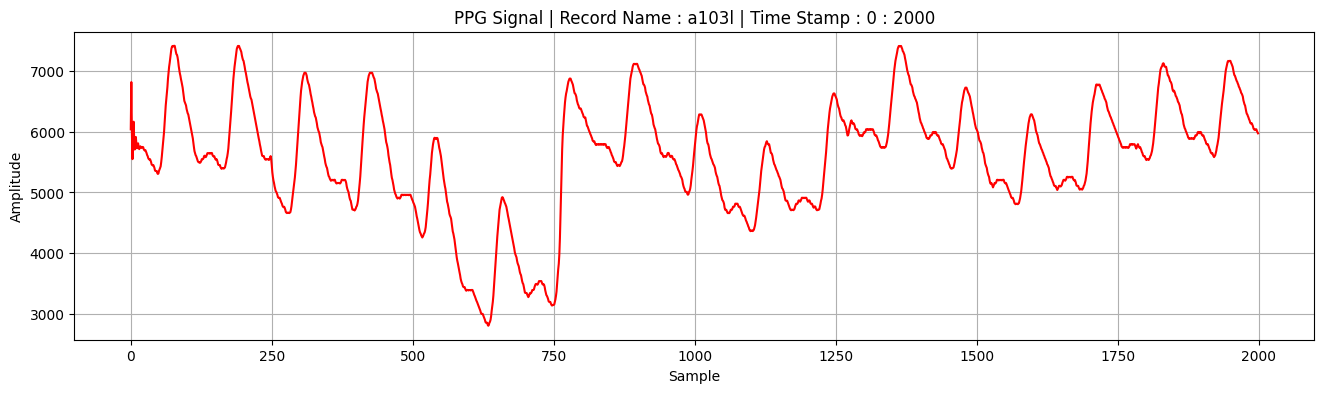

In [20]:

InitialTime = 0
FinalTime = 2000

plt.figure(figsize=(16, 4))
plt.plot(pleth_signal[InitialTime : FinalTime], color='red')
plt.title('PPG Signal | Record Name : ' + str(record_name) +" | Time Stamp : "+ str(InitialTime) + " : " + str(FinalTime))
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [ ]:
pleth_infos = {}
pleth_signals = {}

count = len(patient_ids)
i = 0
for patient_id in patient_ids:

    # Download the files and get their paths
    record_path, hea_file_path = extracting_database(patient_id)

    print("Signal of patient " + str(patient_id) + " extracted")

    # Extract PLETH signal
    pleth_signal = extract_pleth_signal(record_path)
    pleth_signals[patient_id] = pleth_signal

    print("PPG of patient " + str(patient_id) + " loaded")

    # Extract PLETH information
    pleth_info = extract_pleth_info(hea_file_path)
    pleth_infos[patient_id] = pleth_info

    print("Info of patient " + str(patient_id) + " loaded")

    print("PPG and info extracted for " + str(i+1) + " and " + str(count - i - 1) + " left.")

    i += 1


Saved to ./training/v100s.mat
Saved to ./training/v100s.hea
Signal of patient v100s extracted
PPG of patient v100s loaded
Info of patient v100s loaded
PPG and info extracted for 1 and 749 left.
Saved to ./training/v101l.mat
Saved to ./training/v101l.hea
Signal of patient v101l extracted
PPG of patient v101l loaded
Info of patient v101l loaded
PPG and info extracted for 2 and 748 left.
Saved to ./training/v102s.mat
Saved to ./training/v102s.hea
Signal of patient v102s extracted
PPG of patient v102s loaded
Info of patient v102s loaded
PPG and info extracted for 3 and 747 left.
File already exists: ./training/a103l.mat
File already exists: ./training/a103l.hea
Signal of patient a103l extracted
PPG of patient a103l loaded
Info of patient a103l loaded
PPG and info extracted for 4 and 746 left.
Saved to ./training/a104s.mat
Saved to ./training/a104s.hea
Signal of patient a104s extracted
PPG of patient a104s loaded
Info of patient a104s loaded
PPG and info extracted for 5 and 745 left.
Saved 